# GeoSTAD Synthetic Data Pipeline Test

This notebook demonstrates the complete pipeline for generating and evaluating synthetic business location data from the GeoSTAD dataset.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from synlab.data import load_geostad, prepare_for_synthesis, GeoSTADConfig
from synlab.methods import DPMMMSTSynthesizer, DPMMMSTConfig
from synlab.evaluation import (
    compare_basic_stats,
    compare_category_frequencies,
    evaluate_spatial_metrics
)

sns.set_theme()
pd.set_option('display.max_columns', None)

In [2]:
# Auto-reload modules when they change (no need to restart kernel!)
%load_ext autoreload
%autoreload 2

print("✓ Auto-reload enabled - synlab modules will update automatically")

✓ Auto-reload enabled - synlab modules will update automatically


## 2. Load GeoSTAD Data

In [3]:
# Create config and load the real business data
config = GeoSTADConfig()
df_real, domain = load_geostad(config)

print(f"Loaded {len(df_real):,} businesses")
print(f"\nColumns: {df_real.columns.tolist()}")
print(f"\nDomain info:")
for key, value in domain.items():
    if key == 'coordinate_bounds':
        print(f"  {key}: X=[{value['X_min']:.0f}, {value['X_max']:.0f}], Y=[{value['Y_min']:.0f}, {value['Y_max']:.0f}]")
    elif key == 'spatial_info':
        print(f"  {key}: {value}")
    else:
        print(f"  {key}: {len(value) if isinstance(value, dict) else value}")

Filtered to geocoded businesses: 770,568 / 2,252,561 rows
Removed 735 duplicate rows: 769,833 rows remaining
Loaded 769,833 businesses

Columns: ['SN2025', 'orgf2025', 'X_2025', 'Y_2025', 'orgn2025', 'navn2025']

Domain info:
  column_types: 6
  coordinate_bounds: X=[-74800, 1098272], Y=[6449850, 8685966]
  categorical_info: 2
  spatial_info: {}


In [4]:
# Preview the data
df_real.head(10)

,SN2025,orgf2025,X_2025,Y_2025,orgn2025,navn2025
2,90.020,NUF,199000.599174,6.625211e+06,999557244,SOUNDS LIKE NORWAY
3,46.739,AS,288582.250106,6.673567e+06,933735842,GAUSDAL LANDHANDLERI AS
4,68.209,AS,101858.577550,6.467710e+06,999666337,RAFFINERITOMTA EVJE AS
22,49.410,AS,296513.358383,6.670597e+06,925554243,B & Y TRANSPORT AS
25,49.410,AS,-31333.969165,6.742430e+06,999657273,PJT AS
31,62.030,AS,262233.386861,6.648906e+06,911625504,KIRKEPARTNER AS
36,59.110,AS,193941.634284,6.567887e+06,999553435,HULDRA FILM AS
37,41.200,AS,274506.964493,6.911902e+06,999646956,FÅDAL BYGG AS
40,62.030,NUF,271904.466914,6.654436e+06,996345734,NETS BRANCH NORWAY
51,41.200,AS,265351.511278,6.650927e+06,999654592,LENTUS BYGG AS


## 3. Prepare Features for Synthesis

In [10]:
# Select feature columns (excluding identifiers)
# Use ALL data for training (remove sample_size or set to None for full dataset)
# For testing: sample_size=5000, For production: sample_size=None
df_features = prepare_for_synthesis(df_real, config, sample_size=None, random_state=42)

print(f"Feature data: {df_features.shape}")
print(f"Columns: {df_features.columns.tolist()}")
print(f"Using {len(df_features):,} businesses for training")

df_features.head()

Feature data: (769833, 4)
Columns: ['SN2025', 'orgf2025', 'X_2025', 'Y_2025']
Using 769,833 businesses for training


,SN2025,orgf2025,X_2025,Y_2025
2,90.020,NUF,199000.599174,6.625211e+06
3,46.739,AS,288582.250106,6.673567e+06
4,68.209,AS,101858.577550,6.467710e+06
22,49.410,AS,296513.358383,6.670597e+06
25,49.410,AS,-31333.969165,6.742430e+06


### 3.1 Inspect Data Types and Domain

In [11]:
# Check data types in feature dataframe
print("Feature Data Types:")
print("=" * 60)
print(df_features.dtypes)
print("\n\nDomain Metadata:")
print("=" * 60)
print(f"\nColumn types: {domain['column_types']}")
print(f"\nCategorical info:")
for col, info in domain['categorical_info'].items():
    if col in df_features.columns:
        print(f"  {col}: {info['cardinality']} categories")
print(f"\nCoordinate bounds: {domain['coordinate_bounds']}")

# Sample values
print("\n\nSample values per column:")
print("=" * 60)
for col in df_features.columns:
    print(f"{col}: {df_features[col].head(5).tolist()}")

Feature Data Types:
SN2025       object
orgf2025     object
X_2025      float64
Y_2025      float64
dtype: object


Domain Metadata:

Column types: {'SN2025': 'categorical', 'orgf2025': 'categorical', 'X_2025': 'continuous', 'Y_2025': 'continuous', 'orgn2025': 'identifier', 'navn2025': 'identifier'}

Categorical info:
  SN2025: 800 categories
  orgf2025: 34 categories

Coordinate bounds: {'X_min': -74800.421726699, 'X_max': 1098271.9231262, 'Y_min': 6449850.01173696, 'Y_max': 8685966.0}


Sample values per column:
SN2025: ['90.020', '46.739', '68.209', '49.410', '49.410']
orgf2025: ['NUF', 'AS', 'AS', 'AS', 'AS']
X_2025: [199000.599174201, 288582.250106158, 101858.57755, 296513.358383369, -31333.969164754]
Y_2025: [6625211.46167417, 6673566.93269261, 6467710.44962, 6670596.90489438, 6742429.50027436]


## 4. Quick Visualization of Real Data

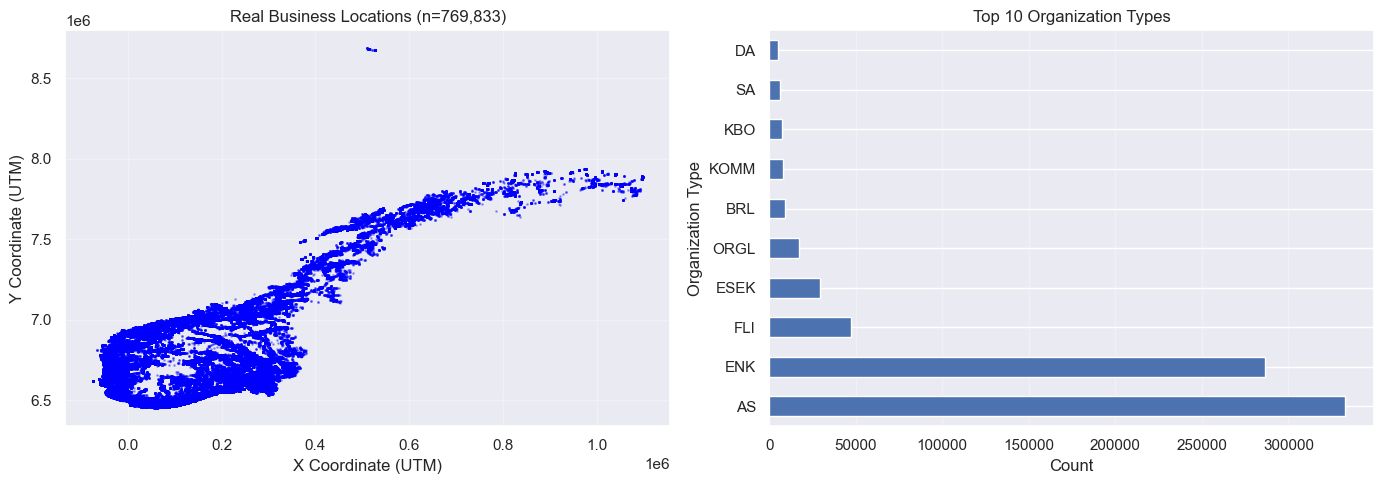

In [12]:
# Geographic distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot of locations
axes[0].scatter(df_features['X_2025'], df_features['Y_2025'], 
                alpha=0.3, s=1, c='blue')
axes[0].set_xlabel('X Coordinate (UTM)')
axes[0].set_ylabel('Y Coordinate (UTM)')
axes[0].set_title(f'Real Business Locations (n={len(df_features):,})')
axes[0].grid(True, alpha=0.3)

# Organization type distribution
df_features['orgf2025'].value_counts().head(10).plot(kind='barh', ax=axes[1])
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Organization Type')
axes[1].set_title('Top 10 Organization Types')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 5. Generate Synthetic Data

We'll test the full pipeline in the notebook by:
1. Configuring the DPMM-MST synthesizer
2. Fitting on real data
3. Generating synthetic data

In [ ]:
# Configure DPMM-MST synthesizer
method_config = DPMMMSTConfig(
    epsilon=30.0,      # Privacy budget (higher = less noise)
    delta=1e-5,       # Privacy failure probability
    proc_epsilon=0.1  # Processing epsilon
)

print("Synthesizer Configuration:")
print(f"  Privacy: ε={method_config.epsilon}, δ={method_config.delta}")
print(f"  Processing ε={method_config.proc_epsilon}")

# Create synthesizer
synthesizer = DPMMMSTSynthesizer(method_config)

# Fit on real data (the synthesizer will show progress)
synthesizer.fit(df_features, domain)

# Generate synthetic data (the synthesizer will show progress)
n_synthetic = 5000  # Generate fewer synthetic records than real (faster)
df_synth = synthesizer.generate(n_synthetic, random_state=42)

# Quick sanity check
print("\nSynthetic Data Sample:")
print("=" * 60)
df_synth.head()

Synthesizer Configuration:
  Privacy: ε=30.0, δ=1e-05
  Processing ε=0.1

Fitting synthesizer on real data...
  Training with: 769,833 businesses
  Feature columns: ['SN2025', 'orgf2025', 'X_2025', 'Y_2025']
  Domain keys: ['column_types', 'coordinate_bounds', 'categorical_info', 'spatial_info']

⏳ This may take 10-30 minutes with full dataset...


PrivacyLeakage: No categorical domain provided for Column SN2025 - will be imputed.
PrivacyLeakage: No categorical domain provided for Column orgf2025 - will be imputed.


✓ Fit complete!

Generating 5,000 synthetic records...
✓ Generated synthetic data: (5000, 4)
Columns: ['SN2025', 'orgf2025', 'X_2025', 'Y_2025']


Synthetic Data Sample:


,SN2025,orgf2025,X_2025,Y_2025
0,87.102,ORGL,194412.894997,7.104787e+06
1,68.209,AS,259271.144241,6.648265e+06
2,96.020,ENK,-50406.582147,6.676454e+06
3,85.510,ENK,656148.083495,7.738616e+06
4,70.220,ENK,257279.001779,6.652102e+06


### 5.1 Debug: Check Synthetic Data

In [14]:
# Detailed comparison of real vs synthetic
print("=" * 80)
print("DATA COMPARISON")
print("=" * 80)

print(f"\n1. SHAPES:")
print(f"   Real: {df_features.shape}")
if 'df_synth' in locals():
    print(f"   Synthetic: {df_synth.shape}")
else:
    print(f"   Synthetic: Not generated yet")
    print("\n⚠️ Run the synthesis cell first!")

if 'df_synth' not in locals():
    print("\nSkipping detailed comparison - no synthetic data available")
else:
    print(f"\n2. COLUMNS:")
    print(f"   Real: {df_features.columns.tolist()}")
    print(f"   Synthetic: {df_synth.columns.tolist()}")
    print(f"   Missing in synthetic: {set(df_features.columns) - set(df_synth.columns)}")

    print(f"\n3. DATA TYPES:")
    print(f"\n   Real:")
    for col in df_features.columns:
        print(f"      {col}: {df_features[col].dtype}")
    print(f"\n   Synthetic:")
    for col in df_synth.columns:
        print(f"      {col}: {df_synth[col].dtype}")

    print(f"\n4. VALUE RANGES:")
    for col in df_synth.columns:
        if col in df_features.columns:
            real_range = (df_features[col].min(), df_features[col].max())
            synth_range = (df_synth[col].min(), df_synth[col].max())
            print(f"   {col}:")
            print(f"      Real:      [{real_range[0]}, {real_range[1]}]")
            print(f"      Synthetic: [{synth_range[0]}, {synth_range[1]}]")

    print(f"\n5. SAMPLE VALUES:")
    print(f"\n   Real (first 5):")
    print(df_features.head())
    print(f"\n   Synthetic (first 5):")
    print(df_synth.head())

    print(f"\n6. CATEGORICAL DISTRIBUTIONS:")
    for col in ['orgf2025', 'SN2025']:
        if col in df_synth.columns:
            print(f"\n   {col} - Top 5 categories:")
            print(f"      Real:")
            print(df_features[col].value_counts().head())
            print(f"      Synthetic:")
            print(df_synth[col].value_counts().head())

DATA COMPARISON

1. SHAPES:
   Real: (769833, 4)
   Synthetic: (5000, 4)

2. COLUMNS:
   Real: ['SN2025', 'orgf2025', 'X_2025', 'Y_2025']
   Synthetic: ['SN2025', 'orgf2025', 'X_2025', 'Y_2025']
   Missing in synthetic: set()

3. DATA TYPES:

   Real:
      SN2025: object
      orgf2025: object
      X_2025: float64
      Y_2025: float64

   Synthetic:
      SN2025: object
      orgf2025: object
      X_2025: float64
      Y_2025: float64

4. VALUE RANGES:
   SN2025:
      Real:      [, 99.000]
      Synthetic: [, 99.000]
   orgf2025:
      Real:      [ANNA, SÆR]
      Synthetic: [ANS, SÆR]
   X_2025:
      Real:      [-74800.421726699, 1098271.9231262]
      Synthetic: [-63117.00438929714, 2076068.3839830474]
   Y_2025:
      Real:      [6449850.01173696, 8685966.0]
      Synthetic: [6342838.715831614, 8362950.818363736]

5. SAMPLE VALUES:

   Real (first 5):
    SN2025 orgf2025         X_2025        Y_2025
2   90.020      NUF  199000.599174  6.625211e+06
3   46.739       AS  288582.2

## 6. Visualize Synthetic vs Real Data

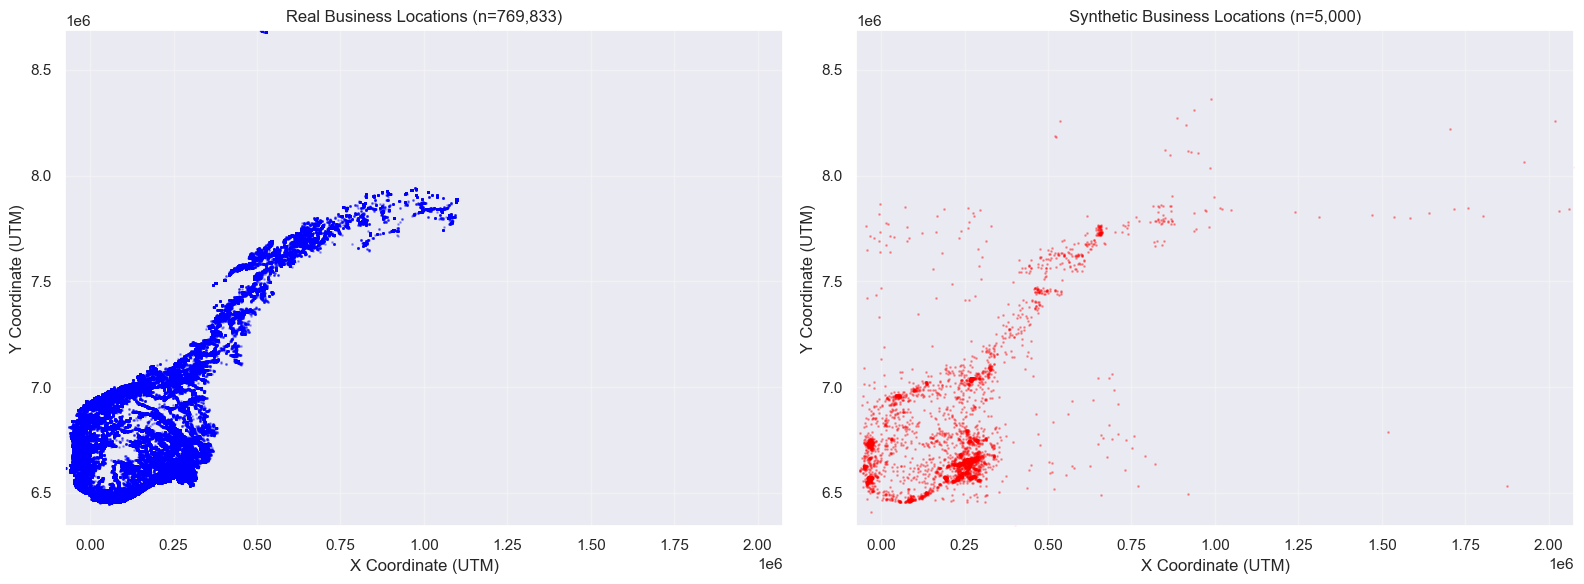


Real data coordinate ranges:
  X: [-74800, 1098272]
  Y: [6449850, 8685966]

Synthetic data coordinate ranges:
  X: [-63117, 2076068]
  Y: [6342839, 8362951]


In [15]:
# Side-by-side geographic comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Real data
axes[0].scatter(df_features['X_2025'], df_features['Y_2025'], 
                alpha=0.3, s=1, c='blue')
axes[0].set_xlabel('X Coordinate (UTM)')
axes[0].set_ylabel('Y Coordinate (UTM)')
axes[0].set_title(f'Real Business Locations (n={len(df_features):,})')
axes[0].grid(True, alpha=0.3)

# Synthetic data
axes[1].scatter(df_synth['X_2025'], df_synth['Y_2025'], 
                alpha=0.3, s=1, c='red')
axes[1].set_xlabel('X Coordinate (UTM)')
axes[1].set_ylabel('Y Coordinate (UTM)')
axes[1].set_title(f'Synthetic Business Locations (n={len(df_synth):,})')
axes[1].grid(True, alpha=0.3)

# Use same axis limits for comparison
x_min = min(df_features['X_2025'].min(), df_synth['X_2025'].min())
x_max = max(df_features['X_2025'].max(), df_synth['X_2025'].max())
y_min = min(df_features['Y_2025'].min(), df_synth['Y_2025'].min())
y_max = max(df_features['Y_2025'].max(), df_synth['Y_2025'].max())

axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(y_min, y_max)
axes[1].set_xlim(x_min, x_max)
axes[1].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

# Print coordinate ranges
print(f"\nReal data coordinate ranges:")
print(f"  X: [{df_features['X_2025'].min():.0f}, {df_features['X_2025'].max():.0f}]")
print(f"  Y: [{df_features['Y_2025'].min():.0f}, {df_features['Y_2025'].max():.0f}]")
print(f"\nSynthetic data coordinate ranges:")
print(f"  X: [{df_synth['X_2025'].min():.0f}, {df_synth['X_2025'].max():.0f}]")
print(f"  Y: [{df_synth['Y_2025'].min():.0f}, {df_synth['Y_2025'].max():.0f}]")

## 7. Quantitative Evaluation

### Basic Statistics

In [8]:
stats = compare_basic_stats(df_features, df_synth)
print("Basic Statistics Comparison:")
print("=" * 60)
stats

Basic Statistics Comparison:


,real_mean,synthetic_mean,diff_mean,real_std,synthetic_std,diff_std,real_min,synthetic_min,diff_min,real_max,synthetic_max,diff_max,real_p25,synthetic_p25,diff_p25,real_p50,synthetic_p50,diff_p50,real_p75,synthetic_p75,diff_p75
column,,,,,,,,,,,,,,,,,,,,,
X_2025,2.168357e+05,2.403354e+05,23499.643440,176981.206260,100104.153936,-76877.052325,-7.435539e+04,1.310724e+05,2.054278e+05,1.098017e+06,5.242599e+05,-573757.293171,9.015378e+04,1.323903e+05,42236.548242,2.543985e+05,2.547131e+05,314.607007,2.712853e+05,2.717558e+05,470.472292
Y_2025,6.784085e+06,6.778268e+06,-5816.124446,308629.075397,320120.386683,11491.311286,6.454774e+06,4.783771e+06,-1.671003e+06,8.683535e+06,8.332107e+06,-351427.737444,6.616543e+06,6.617784e+06,1240.406631,6.652193e+06,6.654143e+06,1950.036785,6.840418e+06,6.851336e+06,10917.068589


### Categorical Distributions

In [9]:
# Organization types
print("Organization Type Distribution:")
print("=" * 60)
cat_freq_org = compare_category_frequencies(
    df_features, df_synth, 
    column='orgf2025', 
    top_k=10
)
display(cat_freq_org)

# Industry codes (SN2025)
print("\n\nIndustry Code Distribution:")
print("=" * 60)
cat_freq_industry = compare_category_frequencies(
    df_features, df_synth, 
    column='SN2025', 
    top_k=10
)
display(cat_freq_industry)

Organization Type Distribution:


TypeError: compare_category_frequencies() got an unexpected keyword argument 'column'

### Spatial Metrics

In [ ]:
# Check if spatial metrics can be computed
if 'grk2025' in df_features.columns and 'grk2025' in df_synth.columns:
    spatial_metrics = evaluate_spatial_metrics(
        df_features, df_synth,
        x_col='X_2025',
        y_col='Y_2025',
        unit_col='grk2025',
        categorical_col='orgf2025'
    )
    
    print("Spatial Quality Metrics:")
    print("=" * 60)
    print("Lower is better for divergence/distance metrics")
    print()
    display(spatial_metrics.T)
else:
    print("⚠️ Skipping spatial metrics - grk2025 not in synthetic data")
    print("   (This is expected since grk2025 was removed from features)")
    print("   To get spatial metrics, you need to reconstruct grk2025 from X/Y coordinates")

Spatial Quality Metrics:
Lower is better for divergence/distance metrics



,0
spatial_js_divergence,0.479205
x_wasserstein,46941.850625
y_wasserstein,13704.799414
nn_distance_ratio,1.957897
nn_distance_wasserstein,4318.811135
unit_js_divergence,0.316090
unit_overlap,0.539768
unit_count_correlation,0.993050
spatial_autocorr_difference,0.077071


## 8. Summary

**Pipeline Test Complete!** ✓

The notebook tests the full pipeline:
1. ✅ Config-based data loading with validation
2. ✅ Feature preparation with sampling
3. ✅ DPMM-MST synthesis with differential privacy
4. ✅ Visual comparison of spatial distributions
5. ✅ Quantitative evaluation (statistics, categories, spatial metrics)

**Next Steps:**
- Adjust privacy parameters (epsilon, delta) for different utility-privacy tradeoffs
- Test with full dataset (remove `sample_size` parameter)
- Use the runner script for production: `python src/synlab/runners/run_geostad_dpmm_mst.py`
- Experiment with different config settings (feature selection, coordinate filtering, etc.)

### Visual Comparison

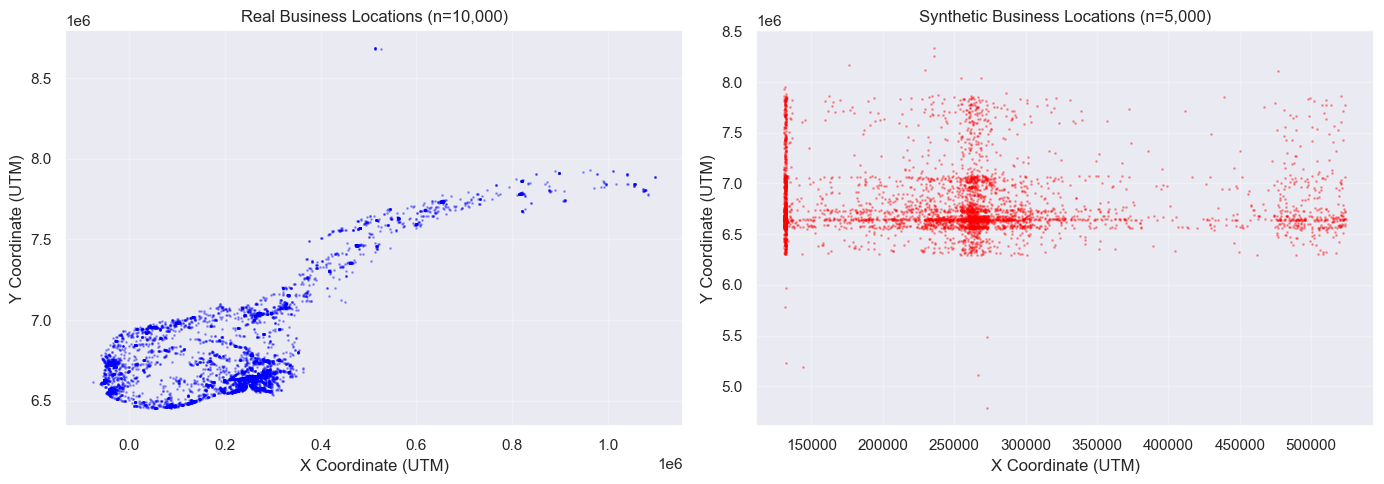

In [11]:
if 'df_synth' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Real data
    axes[0].scatter(df_features['X_2025'], df_features['Y_2025'], 
                    alpha=0.3, s=1, c='blue', label='Real')
    axes[0].set_xlabel('X Coordinate (UTM)')
    axes[0].set_ylabel('Y Coordinate (UTM)')
    axes[0].set_title(f'Real Business Locations (n={len(df_features):,})')
    axes[0].grid(True, alpha=0.3)
    
    # Synthetic data
    axes[1].scatter(df_synth['X_2025'], df_synth['Y_2025'], 
                    alpha=0.3, s=1, c='red', label='Synthetic')
    axes[1].set_xlabel('X Coordinate (UTM)')
    axes[1].set_ylabel('Y Coordinate (UTM)')
    axes[1].set_title(f'Synthetic Business Locations (n={len(df_synth):,})')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Summary

This notebook demonstrates:
1. ✓ Loading GeoSTAD business registry data with the new data loader
2. ✓ Preparing data for synthesis with feature selection
3. ✓ Generating synthetic data using DPMM-MST (via runner script)
4. ✓ Evaluating synthetic data quality with spatial metrics
5. ✓ Visualizing and comparing real vs synthetic distributions

**Next steps:**
- Experiment with different privacy budgets (epsilon values)
- Try different sample sizes for training
- Implement additional spatial evaluation metrics
- Create automated evaluation reports